In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os, subprocess
from itertools import combinations
import scipy
from sklearn.metrics import mean_squared_error

2024-01-02 09:00:46.599943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sequences = pd.read_csv('../data/enformer_sequences.bed', header=None, sep='\t')
bin_index = [447, 448]
model_name = 'enformer'
seq_length = 196608
outdir = utils.make_dir('../results/train_test_valid/')

In [3]:
# Trivial but horrible
for fold in sequences[3].unique():

    cmd = f'less ../data/enformer_sequences.bed | grep {fold}  > tmp.bed;'
    cmd += f'bedtools sort -i tmp.bed > tmp_s.bed;'
    cmd += f'bedtools merge -i tmp_s.bed > {outdir}/enformer_{fold}_sequences_merged.bed; rm tmp.bed tmp_s.bed'
    
    results = subprocess.run(
        cmd, shell=True)


In [5]:
context_test_results = pd.read_csv('../results/summary_csvs/enformer/context_dependence_test.csv')

In [39]:
res_dir_name = 'context_dependence_test_10'
context_test_results = pd.read_csv(f'../results/{res_dir_name}/enformer_result_summary.csv')

In [88]:
sequences_with_tss = []

for path in glob.glob('../results/gencode_tss_predictions/enformer/*npy'):
    ### expand selected TSS sequences to enformer sequence length and save into => ../results/{cell}_tss_selected.bed
    file_prefix = path.split('/')[-1].split('.')[0]
    chrom_i, tss_i = file_prefix.split('_')[1:3]
    start_i, end_i = int(tss_i) - seq_length//2, int(tss_i) + seq_length//2
    if start_i >= 0:
        sequences_with_tss.append([chrom_i, start_i, end_i])
print(len(sequences_with_tss))
pd.DataFrame(sequences_with_tss).to_csv('tmp.bed', sep='\t', header=None, index=None)
    
cmd = f'bedtools sort -i tmp.bed > {outdir}/all_tss_selected.bed; rm tmp.bed'
subprocess.run(cmd, shell=True)

fold_seq_dfs = []
for fold in sequences[3].unique():
    fold_seqs = []
    fold_bed = f'{outdir}/{fold}.bed'
    cmd = f'bedtools intersect -a {outdir}/all_tss_selected.bed -b {outdir}/enformer_{fold}_sequences_merged.bed  -wa -f 1.0 > {fold_bed}'

    subprocess.run(
        cmd, shell=True)
    df = pd.read_csv(fold_bed, header=None, sep='\t')
    df.columns = ['chr', 'start', 'end']
    seq_ids = []
    for i, row in tqdm(df.iterrows()):
        seq_ids.append(glob.glob(f'../results/gencode_tss_predictions/enformer/*{row["chr"]}_{row["start"]+98304}*')[0].split('/')[-1].split('.')[0])#     for i, row in df.iterrows():
    df['seq_id'] = seq_ids
    fold_seq_dfs.append(df)



    

51990


39167it [23:00, 28.38it/s]
3973it [02:19, 28.47it/s]
2502it [01:28, 28.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



67it [00:02, 27.50it/s]


KeyboardInterrupt: 

In [87]:
seq_ids

['RHOU_chr1_228735478_+',
 'LYPD8_chr1_248755759_-',
 'ZNF248_chr10_37857197_-',
 'ZNF248_chr10_37857558_-',
 'ZNF248_chr10_37857610_-',
 'ZNF248_chr10_37857636_-',
 'ZNF25_chr10_37976647_-',
 'ZNF33A_chr10_38010649_+',
 'ZNF33A_chr10_38010654_+',
 'ZNF33A_chr10_38010669_+',
 'ZNF33A_chr10_38010674_+',
 'ZNF33A_chr10_38010685_+',
 'ZNF37A_chr10_38094333_+',
 'ZNF37A_chr10_38094335_+',
 'ZNF37A_chr10_38094336_+',
 'ZNF37A_chr10_38094346_+',
 'PLD5P1_chr10_38094367_+',
 'ANO3_chr11_26188841_+',
 'ANO3_chr11_26309598_+',
 'ANO3_chr11_26332120_+',
 'ANO3_chr11_26332129_+',
 'ANO3_chr11_26473901_+',
 'MUC15_chr11_26567094_-',
 'MUC15_chr11_26572142_-',
 'MUC15_chr11_26572263_-',
 'SLC5A12_chr11_26721999_-',
 'SLC5A12_chr11_26722060_-',
 'FIBIN_chr11_26994111_+',
 'BBOX1_chr11_27040724_+',
 'BBOX1_chr11_27040814_+',
 'BBOX1_chr11_27041312_+',
 'BBOX1_chr11_27055216_+',
 'CCDC34_chr11_27363215_-',
 'CCDC34_chr11_27363234_-',
 'LGR4_chr11_27472314_-',
 'LGR4_chr11_27472775_-',
 'LIN7C_chr11_27

In [86]:
(37758893 + 98304)

37857197

In [49]:
classified_seq_cell = {}
for cell, cell_context_test_results in context_test_results.groupby('cell line'):
    print(cell)
    ### expand selected TSS sequences to enformer sequence length and save into => ../results/{cell}_tss_selected.bed
    sequences_with_tss = []
    for file_prefix in tqdm([p.split('/')[-1].split('.')[0] for p in cell_context_test_results['path']]):
        chrom_i, tss_i = file_prefix.split('_')[1:3]
        start_i, end_i = int(tss_i) - seq_length//2, int(tss_i) + seq_length//2
        if start_i >= 0:
            sequences_with_tss.append([chrom_i, start_i, end_i])
    print(len(sequences_with_tss))
    pd.DataFrame(sequences_with_tss).to_csv('tmp.bed', sep='\t', header=None, index=None)
    
    cmd = f'bedtools sort -i tmp.bed > {outdir}/{cell}_tss_selected.bed; rm tmp.bed'
    r = subprocess.run(cmd, shell=True)
    print(r)
    fold_seq_dfs = []
    for fold in sequences[3].unique():
        fold_seqs = []
        cell_fold_bed = f'../results/{cell}_{fold}.bed'
        cmd = f'bedtools intersect -a {outdir}/{cell}_tss_selected.bed -b {outdir}/enformer_{fold}_sequences_merged.bed  -wa -f 1.0 > {cell_fold_bed}'
    
        subprocess.run(
            cmd, shell=True)
        df = pd.read_csv(cell_fold_bed, header=None, sep='\t')
        for i, row in df.iterrows():
            paths = glob.glob(f'../results/{res_dir_name}/{model_name}/*{row[0]}_{row[1]+seq_length//2}*')
            assert len(paths) > 0, 'File not found'
            fold_seqs.append(paths[0])
        fold_seqs = pd.DataFrame(fold_seqs)
        fold_seqs.columns=['path']
        fold_seqs['fold'] = fold
        fold_seq_dfs.append(fold_seqs)
    fold_seq_dfs = pd.concat(fold_seq_dfs)
    cell_context_test_results['seq_id'] = [p.split('/')[-1] for p in cell_context_test_results['path']]
    fold_seq_dfs['seq_id'] = [p.split('/')[-1] for p in fold_seq_dfs['path']]
    classified_seqs = cell_context_test_results.merge(fold_seq_dfs, on='seq_id')

    classified_seq_cell[cell] = classified_seqs
    

GM12878


100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 970813.81it/s]

9996
CompletedProcess(args='bedtools sort -i tmp.bed > ../results/train_test_valid//GM12878_tss_selected.bed; rm tmp.bed', returncode=0)


K562


100%|███████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1045882.85it/s]

9996
CompletedProcess(args='bedtools sort -i tmp.bed > ../results/train_test_valid//K562_tss_selected.bed; rm tmp.bed', returncode=0)


PC-3


100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 991092.63it/s]

9996
CompletedProcess(args='bedtools sort -i tmp.bed > ../results/train_test_valid//PC-3_tss_selected.bed; rm tmp.bed', returncode=0)


In [61]:
seqid_fold = []
for cell, df in (classified_seq_cell).items():
    df['seq_id'] = [s.split('.')[0] for s in df['seq_id']]
    seqid_fold.append(df[['seq_id', 'cell line', 'fold']])
seqid_fold = pd.concat(seqid_fold)

In [62]:
seqid_fold

,seq_id,cell line,fold
0,ZNF471_chr19_56507854_+,GM12878,test
1,KCTD21_chr11_78188626_-,GM12878,train
2,MEGF8_chr19_42325608_+,GM12878,test
3,ACSF2_chr17_50426217_+,GM12878,train
4,RGS20_chr8_53880893_+,GM12878,train
...,...,...,...
9340,CCT3_chr1_156338257_-,PC-3,train
9341,MDH2_chr7_76048105_+,PC-3,train
9342,HSP90B1_chr12_103930409_+,PC-3,train
9343,ITGB1_chr10_32958230_-,PC-3,train


In [46]:
folds = sequences[3].unique()
pairs = list(combinations(folds, r=2))
x = 'fold'
y ='delta mean'

train valid 0.0005662252372699119
train test 5.717318248860889e-05
valid test 0.8828556970276282


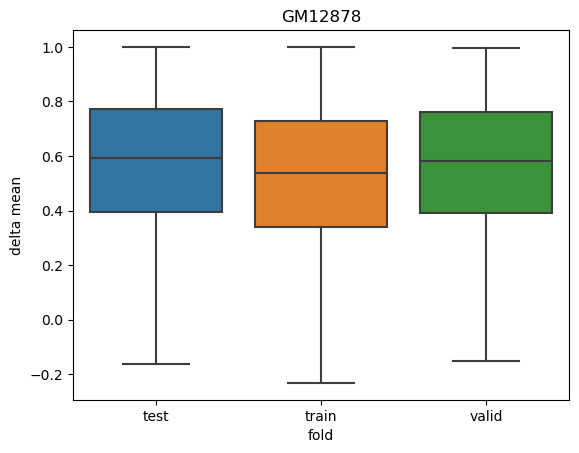

In [48]:
for cell, classified_seqs in classified_seq_cell.items():
    for pair in pairs:
        f1, f2 = pair
        a = classified_seqs[classified_seqs[x]==f1][y]
        b = classified_seqs[classified_seqs[x]==f2][y]
        stat, pvalue = scipy.stats.mannwhitneyu(a, b)
        print(f'{f1} {f2} {pvalue}')

    ax=sns.boxplot(data=classified_seqs, x=x, y=y, showfliers=False)
    plt.title(cell)
    plt.show()

In [26]:
classified_seqs

,Unnamed: 0,delta_mean,path_x,wt,std,mean_mut,seq_id,context,cell_line,path_y,fold
0,0,0.477846,../results//context_dependence_test_100/enform...,14.784366,2.222776,7.719713,XPO5_chr6_43576038_-.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
1,1,0.927049,../results//context_dependence_test_100/enform...,14.783938,0.652025,1.078504,UPK2_chr11_118956297_+.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
2,2,0.879795,../results//context_dependence_test_100/enform...,14.816709,1.007191,1.781050,PLEKHB1_chr11_73647625_+.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
3,3,-1.282113,../results//context_dependence_test_100/enform...,14.803543,6.064398,33.783363,ZNF606_chr19_58002819_-.pickle,silencing,PC-3,../results/context_dependence_test_100/enforme...,train
4,4,0.871365,../results//context_dependence_test_100/enform...,14.812580,1.361411,1.905413,SLC25A30_chr13_45418373_-.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
...,...,...,...,...,...,...,...,...,...,...,...
9339,9995,0.696849,../results//context_dependence_test_100/enform...,447.238680,36.277294,135.580690,CCT3_chr1_156338257_-.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
9340,9996,0.673640,../results//context_dependence_test_100/enform...,449.256040,28.989002,146.619230,MDH2_chr7_76048105_+.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
9341,9997,0.550541,../results//context_dependence_test_100/enform...,451.634580,31.148926,202.991270,HSP90B1_chr12_103930409_+.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
9342,9998,0.529612,../results//context_dependence_test_100/enform...,454.693760,20.745981,213.882630,ITGB1_chr10_32958230_-.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
